In [ ]:
# 모듈 호출
import os
import glob
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/안봐도보이조_project

/content/drive/MyDrive/안봐도보이조_project


# 복수 이미지 삭제

In [ ]:
# 복수 이미지 삭제 함수 정의

def delete_multi_image(img_path): # 삭제하려는 이미지들이 존재하는 경로를 인자로 받음
  
  i = 0 # 처리한 이미지 개수를 세기위해 i 변수 지정
  
  img_folder_list = list(glob.iglob(img_path+'/*')) # 해당 경로 내 모든 폴더 리스트 생성

  for img_folder in img_folder_list: # 해당 경로 내 모든 폴더에 대해 반복
    for img in glob.glob(img_folder+'/*m*.jpg'): # 해당 폴더 내 모든 m이 들어가는 jpg 파일에 대해 반복
      os.remove(img) # 이미지 삭제
      i += 1 # 1회 처리할때마다 i는 1씩증가
  
  print(i,'개의 복수 이미지 삭제') # 총 처리 이미지 개수 출력

In [ ]:
# trian data의 mulit image 삭제
train_path = './train_CAN'
delete_multi_image(train_path)

# valid data 의 mulit image 삭제
valid_path = './valid_CAN'
delete_multi_image(valid_path)

In [ ]:
# img_path = './오리'
# delete_multi_image(img_path)
# 이상없이 작동~

57 개의 복수 이미지 삭제


# Image Resize

In [ ]:
# resize 함수 정의 : openCV사용
def resize_images(img_path, target_size, data_cat): # 이미지 경로, 타겟 사이즈, 데이터 분류(train/valid)

  img_folder_list = glob.glob(img_path+'/*') # 해당 경로 내 모든 폴더 리스트 생성

  for img_folder in img_folder_list: # 해당 경로 내 모든 폴더에 대해 반복
    img_num = 1
    for img in glob.glob(img_folder+'/*.jpg'): # 해당 폴더 내 모든 jpg 파일에 대해 반복
      old_img=cv2.imread(img) # 기존 이미지 열기
      new_img=cv2.resize(old_img,target_size,cv2.INTER_AREA) # 기존 이미지를 target_size로 리사이즈
    
      if not os.path.exists(f'./resize_{data_cat}_{target_size}'):
        os.mkdir(f'./resize_{data_cat}_{target_size}') # 리사이즈한 데이터가 저장될 폴더 생성
      
      product_num = img.split('/')[-1].split('_')[0]

      cv2.imwrite(f'./resize_{data_cat}_{target_size}/{product_num}_{img_num}.jpg', new_img) # 해당 이미지를 상품번호_이미지번호.jpg로 생성한 폴더에 저장

      img_num += 1

  print("Image resize completed!")

In [ ]:
def resize_images(img_path, target_size):

  shutil.copytree(img_path, f'{img_path}_{target_size}') # 원본이미지를 복사
    
  for img in tqdm(glob.glob(f'{img_path}_{target_size}' + '/*/*.jpg')): # 복사한 폴더 내 파일들을 리사이즈해서 대체
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img, "JPG")

In [ ]:
path = './valid_CAN'
resize_images(path,(256,256))

KeyboardInterrupt: ignored

# 불필요한 이미지 삭제

In [ ]:
# 중간에 불필요한 바탕이 존재하는 이미지가 있음
# 수작업으로 제거해야함

# Imbalance 해결

In [ ]:
# 상품번호별 분포 확인
# 분포의 불균형이 심하다면 해결해줘야함

# Image > Numpy Array

In [ ]:
# 이미지를 담을 배열 생성, 데이터타입은 uint8로(이미지는 0~255)
# 폴더에서 하나씩 불러와서 집어넣기
# 각 파일명의 상품번호로부터 상품명 label해주기(상품번호와 상품명 참고표 필요함)

## label 데이터를 만들기 위해 상품 고유번호와 상품명을 컬럼으로 데이터프레임 생성

In [ ]:
path = './train_CAN/*' # 전체 이미지가 존재하는 경로

product_id = [] # 고유번호를 담을 리스트
product_name = [] # 상품명을 담을 리스트

for i in glob.glob(path): # 해당 경로의 모든 파일에 대해
  product_id.append(i.split('/')[-1].split('_')[0]) # 고유번호 리스트에 추가
  product_name.append(i.split('/')[-1].split('_')[1]) # 상품명 리스트에 추가

df = pd.DataFrame({'productID':product_id,'productNAME':product_name}) # 데이터프레임으로 만들기
df.head()
# 수행시간이 짧으므로 굳이 csv파일 생성 하지 않음

,productID,productNAME
0,10013,해태갈배사이다355ML
1,10014,해태갈배사이다238ML
2,10015,롯데핫식스자몽250ML
3,10016,동아오츠카데미소다자몽250ML
4,10017,롯데칸타타아메리카노200ML


In [ ]:
# 경로 내 모든 이미지를 불러와 하나의 numpy array로 만드는 함수 정의

def load_img(path, number_of_data, h_pixel, v_pixel, channel): # 경로, 이미지 총 개수, 가로 픽셀 수, 세로 픽셀 수, 채널 수(흑백/컬러/알파채널여부 등 고려)

    # 이미지 데이터와 라벨 데이터를 담을 matrix 생성
    imgs=np.zeros(number_of_data*h_pixel*v_pixel*channel, dtype=np.uint8).reshape(number_of_data, h_pixel, v_pixel, channel) # 이미지의 데이터는 0~255이기 때문에 데이터타입은 uint8로 지정
    labels=np.zeros(number_of_data,dtype=np.int32) # 라벨로 사용할 고유번호는 최대 90000대이므로 데이터타입 int32

    idx=0 # 순서를 나타낼 인덱스 초기값 지정

    for img in tqdm(glob.glob(path + "/*.jpg")):
      img_array = Image.open(img) # 이미지를 어레이로 불러오기
      imgs[idx,:,:,:]=img_array    # 데이터 영역에 이미지 어레이를 복사
      labels[idx]= img.split('/')[-1].split('_')[0]  # 상품 고유번호를 라벨로 저장
      idx=idx+1 # 순서 +1

    print(f'{number_of_data}개의 이미지 중 {idx}개의 이미지 np.array로 변환 완료')
    return imgs, labels

In [ ]:
path = './resize_train_(256,256)' # 작업할 이미지 경로
number_of_data = len(glob.glob(path+'/*.jpg')) # 해당 경로 내 총 이미지 수
train_img,train_label = load_img(path, number_of_data, 256, 256, 3) # 이미지 불러오기
np.save('./(256,256)_train_img.npy',train_img) # 넘파이 배열 파일로 저장
np.save('./(256,256)_train_label.npy',train_label)
print(train_img.shape,train_label.shape) # 결과 확인

100%|██████████| 11017/11017 [03:26<00:00, 53.27it/s] 


11017개의 이미지 중 11017개의 이미지 np.array로 변환 완료
(11017, 256, 256, 3) (11017,)


In [ ]:
path = './resize_valid_(256,256)'
number_of_data = len(glob.glob(path+'/*.jpg'))
valid_img,valid_label = load_img(path, number_of_data, 256, 256, 3)
np.save('./(256,256)_valid_img.npy',valid_img)
np.save('./(256,256)_valid_label.npy',valid_label)
print(valid_img.shape,valid_label.shape)

100%|██████████| 1456/1456 [00:05<00:00, 288.12it/s]


1456개의 이미지 중 1456개의 이미지 np.array로 변환 완료
(1456, 256, 256, 3) (1456,)


177    해태포도봉봉340ML
Name: productNAME, dtype: object


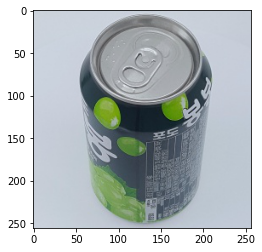

In [ ]:
# 결과 이미지로 확인
img = train_img[133]
plt.imshow(img)
print(df[df['productID']==str(train_label[133])]['productNAME'])

139    오케이에프빅토리아플레인350ML
Name: productNAME, dtype: object


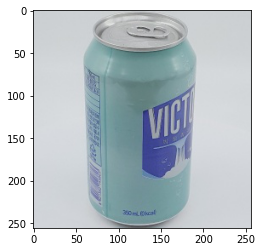

In [ ]:
img = valid_img[133]
plt.imshow(img)
print(df[df['productID']==str(valid_label[133])]['productNAME'])

In [ ]:
del train_img, train_label, valid_img, valid_label # 메모리 용량 확보를 위해 변수 삭제

In [ ]:
# 다른 사이즈에 대해 반복
path = './resize_train_(512,512)'
number_of_data = len(glob.glob(path+'/*.jpg'))
train_img,train_label = load_img(path, number_of_data, 512, 512, 3)
np.save('./(512,512)_train_img.npy',train_img)
np.save('./(512,512)_train_label.npy',train_label)
print(train_img.shape,train_label.shape)

100%|██████████| 11017/11017 [02:05<00:00, 87.72it/s] 


11017개의 이미지 중 11017개의 이미지 np.array로 변환 완료
(11017, 512, 512, 3) (11017,)


In [ ]:
del train_img, train_label

In [ ]:
path = './resize_valid_(512,512)'
number_of_data = len(glob.glob(path+'/*.jpg'))
valid_img,valid_label = load_img(path, number_of_data, 512, 512, 3)
np.save('./(512,512)_valid_img.npy',valid_img)
np.save('./(512,512)_valid_label.npy',valid_label)
print(valid_img.shape,valid_label.shape)

100%|██████████| 1456/1456 [00:20<00:00, 71.05it/s]


1456개의 이미지 중 1456개의 이미지 np.array로 변환 완료
(1456, 512, 512, 3) (1456,)


In [ ]:
del valid_img, valid_label

In [ ]:
# 512 사이즈의 경우 램부족으로 무료 계정에서는 학습 불가능으로 예상
# 추가적으로 이미지 리사이즈 필요할 경우 위 과정 반복

# Image Scaling

In [ ]:
# 저장한 이미지 어레이 불러오기
train_img = np.load('./(256,256)_train_img.npy')
train_label = np.load('./(256,256)_train_label.npy')
valid_img = np.load('./(256,256)_valid_img.npy')
valid_label = np.load('./(256,256)_valid_label.npy')

# 스케일링 # 램용량 초과....

KeyboardInterrupt: ignored

# 모델링

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) # 이미 제너레이터로 생성해서 저장했으므로 스케일링만 진행
train_generator = train_datagen.flow_from_directory(
    './train_8',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(128, 128)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 이미 제너레이터로 생성해서 저장했으므로 스케일링만 진행
valid_generator = train_datagen.flow_from_directory(
    './valid_8',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(128, 128)) 

Found 8500 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [ ]:
print(train_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '밀키스': 2, '스프라이트': 3, '칠성사이다': 4, '코카콜라': 5, '펩시콜라': 6, '환타오렌지': 7}


In [ ]:
print(valid_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '밀키스': 2, '스프라이트': 3, '칠성사이다': 4, '코카콜라': 5, '펩시콜라': 6, '환타오렌지': 7}


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation = 'relu')) 
model.add(keras.layers.Dense(8, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10) # 10번동안 성능개선이 없으면 학습 조기종료
history = model.fit(train_generator,
                    steps_per_epoch=100, 
                    epochs=10, 
                    validation_data=valid_generator, 
                    validation_steps=20,
                    callbacks=[earlystopping]) 

Epoch 1/10
100/100 [==============================] - 414s 4s/step - loss: 1.6962 - accuracy: 0.2740 - val_loss: 1.3366 - val_accuracy: 0.4850
Epoch 2/10
100/100 [==============================] - 359s 4s/step - loss: 1.2014 - accuracy: 0.4500 - val_loss: 1.0664 - val_accuracy: 0.4850
Epoch 3/10
100/100 [==============================] - 302s 3s/step - loss: 0.6706 - accuracy: 0.7290 - val_loss: 0.3947 - val_accuracy: 0.8700
Epoch 4/10
100/100 [==============================] - 266s 3s/step - loss: 0.4016 - accuracy: 0.8310 - val_loss: 0.4505 - val_accuracy: 0.8500
Epoch 5/10
100/100 [==============================] - 228s 2s/step - loss: 0.2891 - accuracy: 0.8860 - val_loss: 0.2586 - val_accuracy: 0.9050
Epoch 6/10
100/100 [==============================] - 194s 2s/step - loss: 0.2600 - accuracy: 0.9010 - val_loss: 0.2883 - val_accuracy: 0.8900
Epoch 7/10
100/100 [==============================] - 172s 2s/step - loss: 0.2324 - accuracy: 0.9030 - val_loss: 0.1554 - val_accuracy: 0.9250

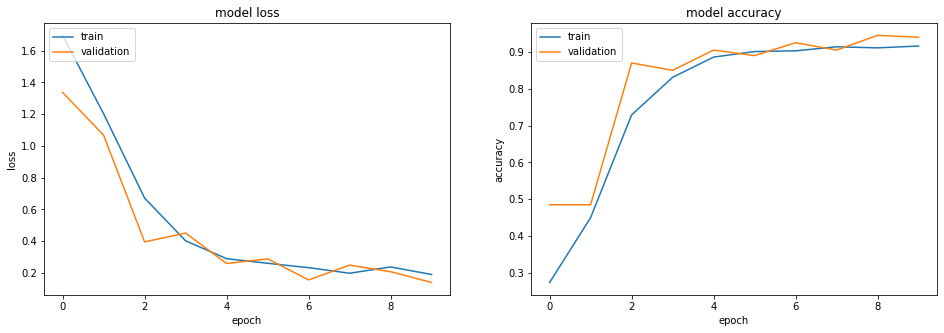

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
model.save('8_class_model.h5')

In [ ]:
test_img = cv2.imread('./2205722_1.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[1.6340387e-07, 7.8246671e-23, 0.0000000e+00, 7.2735387e-27,
        0.0000000e+00, 5.6910939e-12, 2.4373948e-23, 9.9999988e-01]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./train_8/펩시콜라/40033_1.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[4.0927524e-05, 1.6550149e-12, 5.4828980e-21, 4.6388623e-15,
        6.7466557e-20, 1.6815231e-05, 5.9765151e-11, 9.9994230e-01]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./11.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[4.6775480e-13, 9.9964023e-01, 5.5402503e-13, 1.2498013e-12,
        1.9131510e-10, 5.8553169e-11, 3.5975358e-04, 3.1092815e-09]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./train_8/환타오렌지/10052_29.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[9.6325579e-09, 9.9281001e-01, 4.9082065e-13, 5.3187083e-10,
        7.8098944e-10, 3.4955036e-08, 7.1817371e-03, 8.2946317e-06]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./train_8/갈아만든배/10014_.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[2.6997512e-05, 9.7312498e-01, 4.4729328e-04, 4.6506108e-04,
        1.2555273e-03, 5.5692162e-06, 2.4591973e-02, 8.2480277e-05]],
      dtype=float32)